In [27]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.impute import KNNImputer
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error, mean_absolute_error

In [40]:
df = pd.read_csv(
    "electricity.csv",
    low_memory=False
)
df["datetime"] = pd.to_datetime(
    df["Date"] + " " + df["Time"],
    format="%d/%m/%Y %H:%M:%S",
    errors="coerce"
)
df = df.drop("Date", axis=1)
df = df.drop("Time", axis=1)
df = df.set_index("datetime")
df.head()

,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
datetime,,,,,,,
2006-12-16 17:24:00,4.216,0.418,234.84,18.4,0.0,1.0,17.0
2006-12-16 17:25:00,5.360,0.436,233.63,23.0,0.0,1.0,16.0
2006-12-16 17:26:00,5.374,0.498,233.29,23.0,0.0,2.0,17.0
2006-12-16 17:27:00,5.388,0.502,233.74,23.0,0.0,1.0,17.0
2006-12-16 17:28:00,3.666,0.528,235.68,15.8,0.0,1.0,17.0


In [29]:
#checkimg null values
df.isnull().sum()

,0
Global_active_power,25979
Global_reactive_power,25979
Voltage,25979
Global_intensity,25979
Sub_metering_1,25979
Sub_metering_2,25979
Sub_metering_3,25979


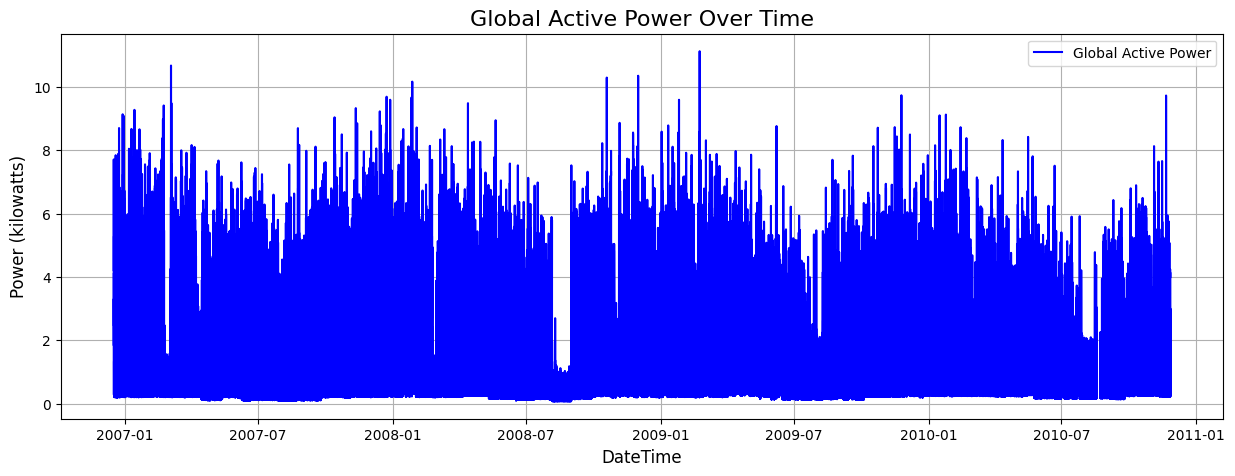

/tmp/ipython-input-171107608.py:11: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  monthly_avg = df['Global_active_power'].resample('M').mean()
/tmp/ipython-input-171107608.py:13: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  monthly_total = df['Global_active_power'].resample('M').sum()


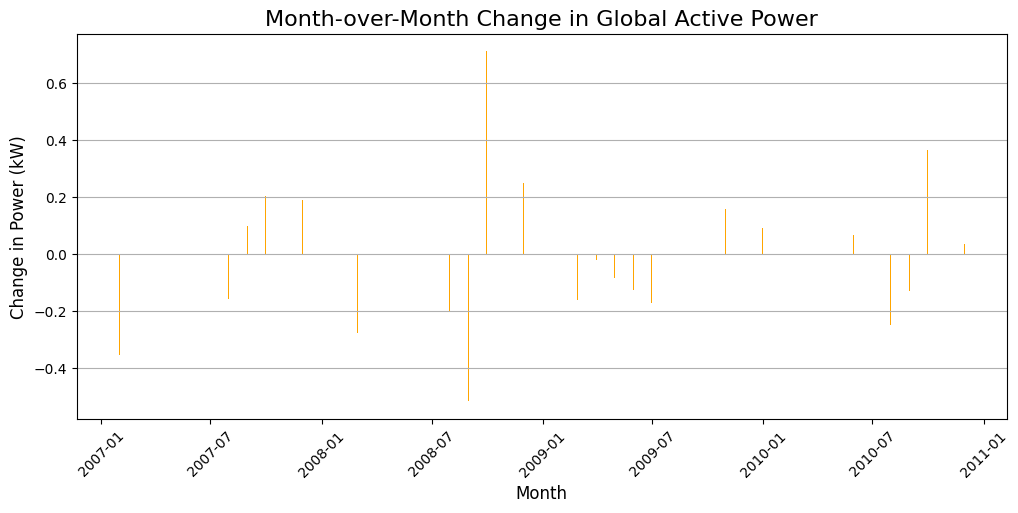

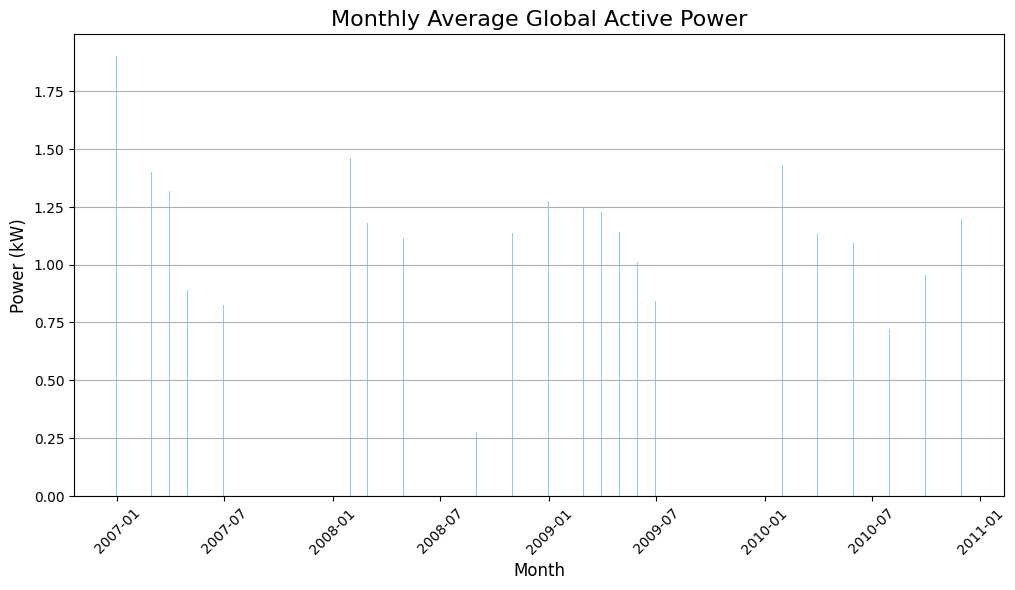

In [49]:
#exploratory data analysis
plt.figure(figsize=(15,5))
plt.plot(df.index, df['Global_active_power'], label='Global Active Power', color='blue')
plt.title('Global Active Power Over Time', fontsize=16)
plt.xlabel('DateTime', fontsize=12)
plt.ylabel('Power (kilowatts)', fontsize=12)
plt.grid(True)
plt.legend()
plt.show()

monthly_avg = df['Global_active_power'].resample('M').mean()
monthly_change = monthly_avg.diff()  # difference between consecutive months
monthly_total = df['Global_active_power'].resample('M').sum()

plt.figure(figsize=(12,5))
plt.bar(monthly_change.index, monthly_change, color='orange')
plt.title('Month-over-Month Change in Global Active Power', fontsize=16)
plt.xlabel('Month', fontsize=12)
plt.ylabel('Change in Power (kW)', fontsize=12)
plt.xticks(rotation=45)
plt.grid(axis='y')
plt.show()

plt.figure(figsize=(12,6))
plt.bar(monthly_avg.index, monthly_avg, color='skyblue')  # use monthly_total if you want total usage
plt.title('Monthly Average Global Active Power', fontsize=16)
plt.xlabel('Month', fontsize=12)
plt.ylabel('Power (kW)', fontsize=12)
plt.xticks(rotation=45)
plt.grid(axis='y')
plt.show()


In [46]:
#testing importing strategies
df_sample = df.sample(100000, random_state = 42).copy()
numeric_cols = df_sample.select_dtypes(include=np.number).columns
#simulate missingness on known columns
df_missing = df_sample.copy()
mask = np.random.rand(*df_missing[numeric_cols].shape) < 0.1
df_missing.loc[:, numeric_cols] = df_missing[numeric_cols].mask(mask)
#ground truth
true_values = df_sample[numeric_cols][mask]

#1 median
df_median = df_missing.fillna(df_missing.median(numeric_only=True))

#2 interpolation
df_interp = df_missing.copy()
df_interp[numeric_cols] = df_interp[numeric_cols].interpolate(
    method="time",
    limit_direction="both"
)

# 3. hybrid (Median first, then Time Interpolation)
df_hybrid = df_missing.copy()

# Step 1: fill big holes with median
df_hybrid[numeric_cols] = df_hybrid[numeric_cols].fillna(
    df_missing[numeric_cols].median()
)

# Step 2: smooth over with time interpolation
df_hybrid[numeric_cols] = df_hybrid[numeric_cols].interpolate(
    method="time",
    limit_direction="both"
)

print("NaNs in ground truth:", true_values.isna().sum().sum())
print("NaNs in Median imput:", df_median[numeric_cols].isna().sum().sum())
print("NaNs in Interp imput:", df_interp[numeric_cols].isna().sum().sum())
print("NaNs in Hybrid imput:", df_hybrid[numeric_cols].isna().sum().sum())

def evaluate(imputed, name):
    pred_values = imputed[numeric_cols][mask].to_numpy().ravel()
    true_vals   = true_values.to_numpy().ravel()

    # Stack both to drop rows where either side is NaN
    both = np.vstack([true_vals, pred_values]).T
    both = both[~np.isnan(both).any(axis=1)]

    if both.shape[0] == 0:
        return {"Method": name, "RMSE": np.nan, "MAE": np.nan}

    rmse = mean_squared_error(both[:, 0], both[:, 1]) ** 0.5
    mae = mean_absolute_error(both[:, 0], both[:, 1])
    return {"Method": name, "RMSE": rmse, "MAE": mae}


results = []
results.append(evaluate(df_median, "Median"))
results.append(evaluate(df_interp, "Interpolation"))
results.append(evaluate(df_hybrid, "Hybrid (Median + Time Interp)"))

# 5. Compare results
print(results)
results_df = pd.DataFrame(results)
print(results_df)

NaNs in ground truth: 6391
NaNs in Median imput: 0
NaNs in Interp imput: 0
NaNs in Hybrid imput: 0
[{'Method': 'Median', 'RMSE': 2.675390078457789, 'MAE': 0.5093182874874865}, {'Method': 'Interpolation', 'RMSE': 1.5972372586462606, 'MAE': 0.22091978036849622}, {'Method': 'Hybrid (Median + Time Interp)', 'RMSE': 2.675390078457789, 'MAE': 0.5093182874874865}]
                          Method      RMSE       MAE
0                         Median  2.675390  0.509318
1                  Interpolation  1.597237  0.220920
2  Hybrid (Median + Time Interp)  2.675390  0.509318


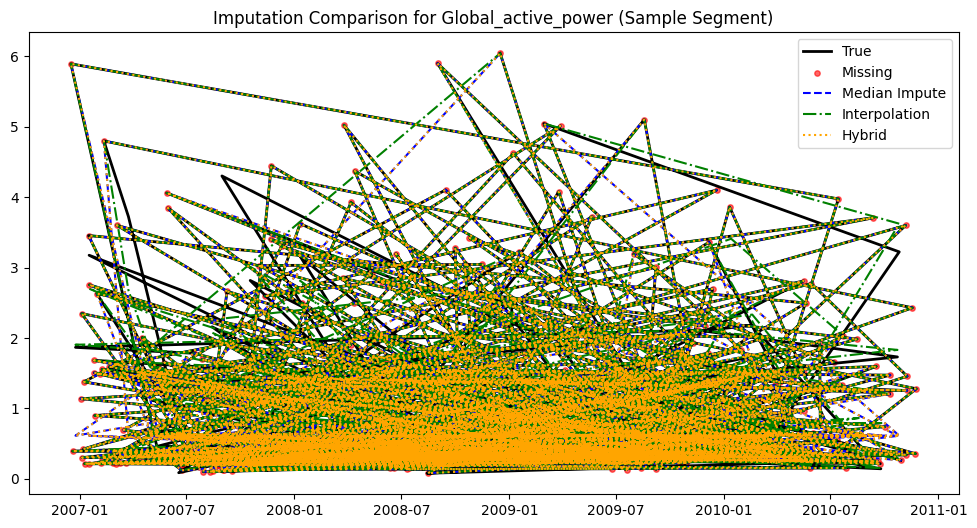

/tmp/ipython-input-1275055567.py:34: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(


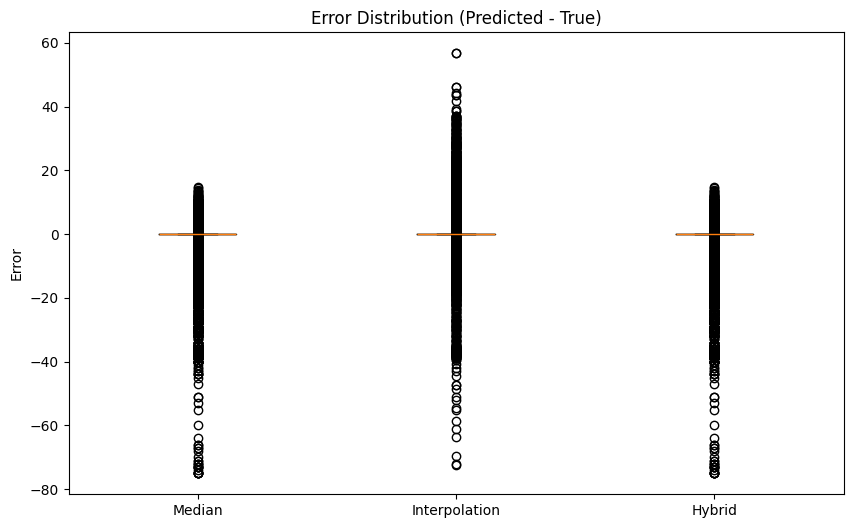

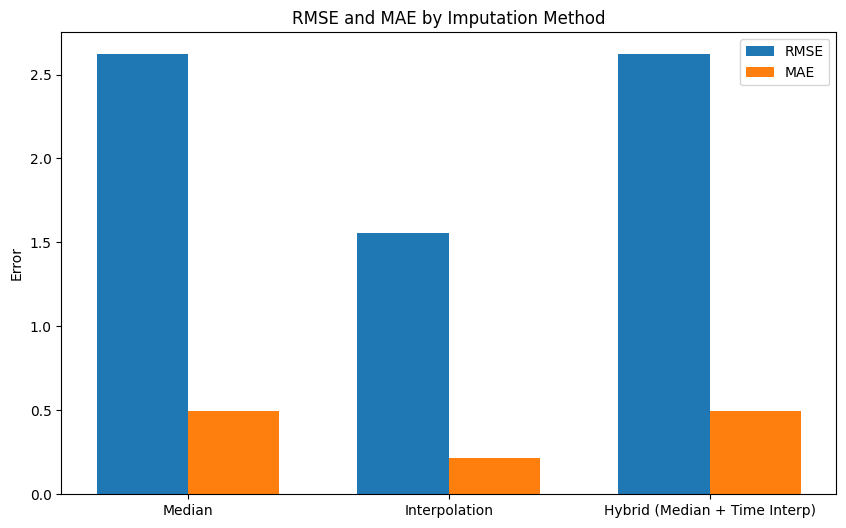

In [39]:
import matplotlib.pyplot as plt

# --------------------------
# 1. Sample Segment Plot
# --------------------------
# Pick one numeric column and a short time window
col = numeric_cols[0]
segment = df_sample[col].iloc[:500]   # first 500 rows (adjust as needed)

missing_segment = df_missing[col].iloc[:500]
median_segment = df_median[col].iloc[:500]
interp_segment = df_interp[col].iloc[:500]
hybrid_segment = df_hybrid[col].iloc[:500]

plt.figure(figsize=(12,6))
plt.plot(segment.index, segment, label="True", color="black", linewidth=2)
plt.scatter(missing_segment.index, missing_segment, label="Missing", color="red", s=15, alpha=0.6)
plt.plot(median_segment.index, median_segment, label="Median Impute", color="blue", linestyle="--")
plt.plot(interp_segment.index, interp_segment, label="Interpolation", color="green", linestyle="-.")
plt.plot(hybrid_segment.index, hybrid_segment, label="Hybrid", color="orange", linestyle=":")
plt.legend()
plt.title(f"Imputation Comparison for {col} (Sample Segment)")
plt.show()


# --------------------------
# 2. Error Distribution
# --------------------------
median_errors = (df_median[numeric_cols] - df_sample[numeric_cols]).values.flatten()
interp_errors = (df_interp[numeric_cols] - df_sample[numeric_cols]).values.flatten()
hybrid_errors = (df_hybrid[numeric_cols] - df_sample[numeric_cols]).values.flatten()

plt.figure(figsize=(10,6))
plt.boxplot(
    [median_errors[~np.isnan(median_errors)],
     interp_errors[~np.isnan(interp_errors)],
     hybrid_errors[~np.isnan(hybrid_errors)]],
    labels=["Median", "Interpolation", "Hybrid"]
)
plt.title("Error Distribution (Predicted - True)")
plt.ylabel("Error")
plt.show()


# --------------------------
# 3. RMSE & MAE Bar Chart
# --------------------------
x = np.arange(len(results_df))
width = 0.35

plt.figure(figsize=(10,6))
plt.bar(x - width/2, results_df["RMSE"], width, label="RMSE")
plt.bar(x + width/2, results_df["MAE"], width, label="MAE")
plt.xticks(x, results_df["Method"])
plt.ylabel("Error")
plt.title("RMSE and MAE by Imputation Method")
plt.legend()
plt.show()


In [ ]:
#feature engineering
#1 lag features

#2 rolling features

